# **Proyek Klasifikasi Gambar Batu Gunting Kertas**

Nama : Picessa Kresna

In [6]:
import urllib.request
import zipfile
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [7]:
data_url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'

urllib.request.urlretrieve(data_url, 'rockpaperscissors.zip')
local_file = 'rockpaperscissors.zip'

zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [8]:
training_dir = 'data/rockpaperscissors/rps-cv-images'

training_datagen = ImageDataGenerator(
    rescale=1. / 255,               # Normalisasi piksel ke rentang [0, 1]
    shear_range=0.2,                # Efek shear (geser) pada gambar
    zoom_range=0.2,                 # Efek zoom pada gambar
    horizontal_flip=True,           # Efek flip horizontal (mirror)
    validation_split=0.4,           # Pembagian data menjadi pelatihan dan validasi
    rotation_range=40,              # Rentang rotasi gambar
    width_shift_range=0.2,          # Rentang pergeseran horizontal
    height_shift_range=0.2,         # Rentang pergeseran vertikal
    fill_mode='nearest'             # Metode pengisian piksel yang hilang
)

# Membuat generator untuk data pelatihan
train_generator = training_datagen.flow_from_directory(
    training_dir,
    color_mode="grayscale",         # Mode warna grayscale (skala abu-abu)
    target_size=(150, 150),         # Ukuran gambar target
    batch_size=128,                 # Ukuran batch data
    class_mode='categorical',       # Mode kelas kategori (untuk klasifikasi)
    subset='training'               # Subset data pelatihan
)

# Membuat generator untuk data validasi
validation_generator = training_datagen.flow_from_directory(
    training_dir,
    color_mode="grayscale",         # Mode warna grayscale (skala abu-abu)
    target_size=(150, 150),         # Ukuran gambar target
    batch_size=128,                 # Ukuran batch data
    class_mode='categorical',       # Mode kelas kategori (untuk klasifikasi)
    subset='validation'             # Subset data validasi
)

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


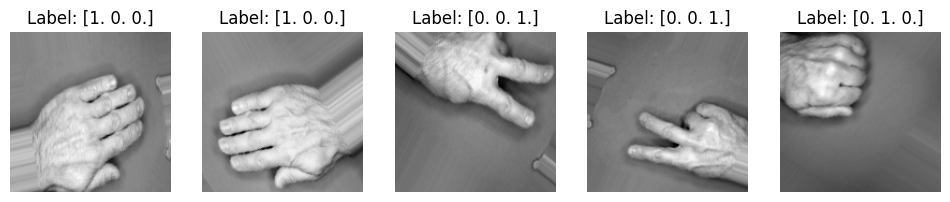

In [9]:
# Ambil satu batch gambar dari train_generator
batch = next(train_generator)

# Pisahkan gambar dan label
images, labels = batch

# Tampilkan beberapa gambar dari batch tersebut
plt.figure(figsize=(12, 6))
for i in range(5):                      # Menampilkan 5 gambar pertama dari batch
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')  # Menampilkan gambar dalam skala abu-abu (grayscale)
    plt.title(f'Label: {labels[i]}')    # Menampilkan label pada gambar
    plt.axis('off')

plt.show()

In [10]:
# Membuat model neural network menggunakan Sequential, yang berarti kita akan membuat model secara sekuensial.
model = tf.keras.models.Sequential([
    # Layer konvolusi pertama: Terdiri dari 64 filter dengan ukuran kernel 3x3, aktivasi ReLU, dan input gambar berukuran 150x150 piksel dengan 1 saluran warna (grayscale).
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    # Layer MaxPooling pertama: Mengurangi resolusi gambar dengan faktor 2.
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer konvolusi kedua: Terdiri dari 64 filter dengan ukuran kernel 3x3 dan aktivasi ReLU.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # Layer MaxPooling kedua: Mengurangi resolusi gambar dengan faktor 2.
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer konvolusi ketiga: Terdiri dari 128 filter dengan ukuran kernel 3x3 dan aktivasi ReLU.
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # Layer MaxPooling ketiga: Mengurangi resolusi gambar dengan faktor 2.
    tf.keras.layers.MaxPooling2D(2, 2),

    # Layer konvolusi keempat: Terdiri dari 128 filter dengan ukuran kernel 3x3 dan aktivasi ReLU.
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    # Layer MaxPooling keempat: Mengurangi resolusi gambar dengan faktor 2.
    tf.keras.layers.MaxPooling2D(2, 2),

    # Flatten layer: Mengubah tensor menjadi vektor satu dimensi.
    tf.keras.layers.Flatten(),

    # Fully connected layer (Dense): Terdiri dari 512 neuron dengan aktivasi ReLU.
    tf.keras.layers.Dense(512, activation='relu'),

    # Output layer: Terdiri dari 3 neuron (karena ada 3 kategori klasifikasi: batu, gunting, kertas) dengan aktivasi softmax.
    tf.keras.layers.Dense(3, activation='softmax')
])

In [11]:
# Mendefinisikan callback kustom ModelCallback
class ModelCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        # Mengecek apakah akurasi pelatihan (accuracy) dan akurasi validasi (val_accuracy) lebih besar dari 0.96 (96%)
        if logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96:
            # Jika kondisi terpenuhi, mengatur atribut 'stop_training' dari model menjadi True
            self.model.stop_training = True

In [12]:
# Inisialisasi optimizer menggunakan Adam
optimizer = Adam()

# Inisialisasi fungsi kerugian (loss function) sebagai categorical cross-entropy
loss_function = 'categorical_crossentropy'

# Kompilasi model:
# - Menggunakan optimizer Adam yang telah diinisialisasi sebelumnya.
# - Menggunakan loss function categorical cross-entropy.
# - Menggunakan metrik akurasi untuk evaluasi performa model.
model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy']
)

# Membuat instance dari ModelCallback
stop_callback = ModelCallback()

# Melakukan pelatihan model:
# - Menggunakan data pelatihan dari train_generator.
# - Melakukan pelatihan selama 100 epoch (siklus pelatihan).
# - Menggunakan data validasi dari validation_generator untuk evaluasi model.
# - Menggunakan callback stop_callback untuk menghentikan pelatihan jika kriteria terpenuhi.
model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=stop_callback
)

Epoch 1/100
11/11 [==============================] - 21s 1s/step - loss: 1.1393 - accuracy: 0.3516 - val_loss: 1.1014 - val_accuracy: 0.3432
Epoch 2/100
11/11 [==============================] - 9s 802ms/step - loss: 1.1008 - accuracy: 0.3432 - val_loss: 1.0979 - val_accuracy: 0.3432
Epoch 3/100
11/11 [==============================] - 10s 919ms/step - loss: 1.0980 - accuracy: 0.3425 - val_loss: 1.0957 - val_accuracy: 0.3432
Epoch 4/100
11/11 [==============================] - 12s 1s/step - loss: 1.0928 - accuracy: 0.3683 - val_loss: 1.0943 - val_accuracy: 0.3318
Epoch 5/100
11/11 [==============================] - 10s 906ms/step - loss: 1.0974 - accuracy: 0.3790 - val_loss: 1.0858 - val_accuracy: 0.4600
Epoch 6/100
11/11 [==============================] - 9s 803ms/step - loss: 1.0712 - accuracy: 0.4589 - val_loss: 1.0341 - val_accuracy: 0.4165
Epoch 7/100
11/11 [==============================] - 9s 913ms/step - loss: 0.9740 - accuracy: 0.5046 - val_loss: 0.9425 - val_accuracy: 0.5686
E

Saving 1MOm36DHK0R8OfIC.png to 1MOm36DHK0R8OfIC.png
1/1 [==============================] - 0s 404ms/step
1MOm36DHK0R8OfIC.png
Prediction: rock


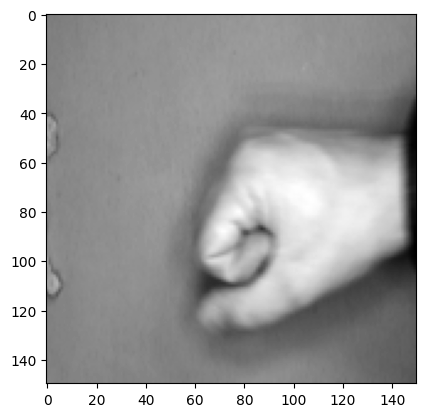

In [13]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2  # Untuk konversi RGB ke Grayscale
%matplotlib inline

uploaded = files.upload()


for fn in uploaded.keys():
    # Load gambar RGB yang diunggah
    path = fn
    rgb_img = mpimg.imread(path)

    # Ubah gambar RGB menjadi grayscale
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

    # Ubah ukuran gambar sesuai dengan yang diharapkan oleh model
    target_size = (150, 150)
    gray_img = cv2.resize(gray_img, target_size)

    imgplot = plt.imshow(gray_img, cmap='gray')  # Tampilkan gambar grayscale
    x = image.img_to_array(gray_img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)

    # Menentukan hasil klasifikasi berdasarkan nilai probabilitas tertinggi
    class_labels = ["paper", "rock",  "scissors"]
    predicted_class = class_labels[np.argmax(classes)]

    print(fn)
    print("Prediction:", predicted_class)
